# Tractor Auction

There's a dataset on kaggle.com containing sale data from an auction of tractors. It's a csv. Its columns contain continuous and categorical features. Some of the data are missing or invalid in some way. There is also a test set against which I can submit predictions to see how accurately my model generalizes to that test set.

My goal is to download the dataset, inspect the data, prepare it for training, train a model, make predictions, and then iterate to see if I can improve on my score it.  

In [4]:
import pathlib
import fastbook
import kaggle
import shutil

def get_kaggle_dataset(comp):
    kaggle_api_credentials = pathlib.Path('~/.kaggle/kaggle.json').expanduser().read_text()
    path = fastbook.URLs.path(comp)
    if path.exists():
        print(path, "already exists.")
        return path
    path.mkdir(parents=True)
    kaggle.api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))
    return path

# https://www.kaggle.com/c/bluebook-for-bulldozers
path = get_kaggle_dataset("bluebook-for-bulldozers")

100%|██████████| 48.4M/48.4M [00:00<00:00, 102MB/s] 


In [13]:
path.ls().sorted().map(print)
None

/home/john/.fastai/archive/bluebook-for-bulldozers/Data Dictionary.xlsx
/home/john/.fastai/archive/bluebook-for-bulldozers/Machine_Appendix.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/Test.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/Train.7z
/home/john/.fastai/archive/bluebook-for-bulldozers/Train.zip
/home/john/.fastai/archive/bluebook-for-bulldozers/TrainAndValid.7z
/home/john/.fastai/archive/bluebook-for-bulldozers/TrainAndValid.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/TrainAndValid.zip
/home/john/.fastai/archive/bluebook-for-bulldozers/Valid.7z
/home/john/.fastai/archive/bluebook-for-bulldozers/Valid.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/Valid.zip
/home/john/.fastai/archive/bluebook-for-bulldozers/ValidSolution.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/bluebook-for-bulldozers.zip
/home/john/.fastai/archive/bluebook-for-bulldozers/median_benchmark.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/random_forest_be

In [21]:
path.ls().sorted().map(lambda f: str(f).endswith("csv") and print(f))
None

/home/john/.fastai/archive/bluebook-for-bulldozers/Machine_Appendix.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/Test.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/TrainAndValid.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/Valid.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/ValidSolution.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/median_benchmark.csv
/home/john/.fastai/archive/bluebook-for-bulldozers/random_forest_benchmark_test.csv


In [29]:
from IPython.display import display, Markdown
def md(s):
    display(Markdown(s))

In [53]:
import pandas as pd

def inspect(name):
    md(f"# {name}")
    df = pd.read_csv(path/f'{name}', low_memory=False)
    md(f"## ({len(df.columns)}) Columns:")
    print(df.columns)
    return df.head()

In [62]:
inspect('Machine_Appendix.csv')
#inspect('Test.csv')
#inspect('TrainAndValid.csv')
#inspect('Valid.csv')
#inspect('ValidSolution.csv')
#inspect('median_benchmark.csv')
#inspect('random_forest_benchmark_test.csv')


# Machine_Appendix.csv

## (16) Columns:

Index(['MachineID', 'ModelID', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'fiProductClassDesc',
       'ProductGroup', 'ProductGroupDesc', 'MfgYear', 'fiManufacturerID',
       'fiManufacturerDesc', 'PrimarySizeBasis', 'PrimaryLower',
       'PrimaryUpper'],
      dtype='object')


,MachineID,ModelID,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,fiProductClassDesc,ProductGroup,ProductGroupDesc,MfgYear,fiManufacturerID,fiManufacturerDesc,PrimarySizeBasis,PrimaryLower,PrimaryUpper
0,113,1355,350L,350,NaN,NaN,L,"Hydraulic Excavator, Track - 50.0 to 66.0 Metric Tons",TEX,Track Excavators,1994.0,26,Caterpillar,Weight - Metric Tons,50.0,66.0
1,434,3538,416C,416,C,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,BL,Backhoe Loaders,1997.0,26,Caterpillar,Standard Digging Depth - Ft,14.0,15.0
2,534,3538,416C,416,C,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,BL,Backhoe Loaders,1998.0,26,Caterpillar,Standard Digging Depth - Ft,14.0,15.0
3,718,3538,416C,416,C,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,BL,Backhoe Loaders,2000.0,26,Caterpillar,Standard Digging Depth - Ft,14.0,15.0
4,1753,1580,D5GLGP,D5,G,NaN,LGP,"Track Type Tractor, Dozer - 85.0 to 105.0 Horsepower",TTT,Track Type Tractors,2006.0,26,Caterpillar,Horsepower,85.0,105.0


In [64]:
df = pd.read_csv(path/"TrainAndValid.csv", low_memory=False)

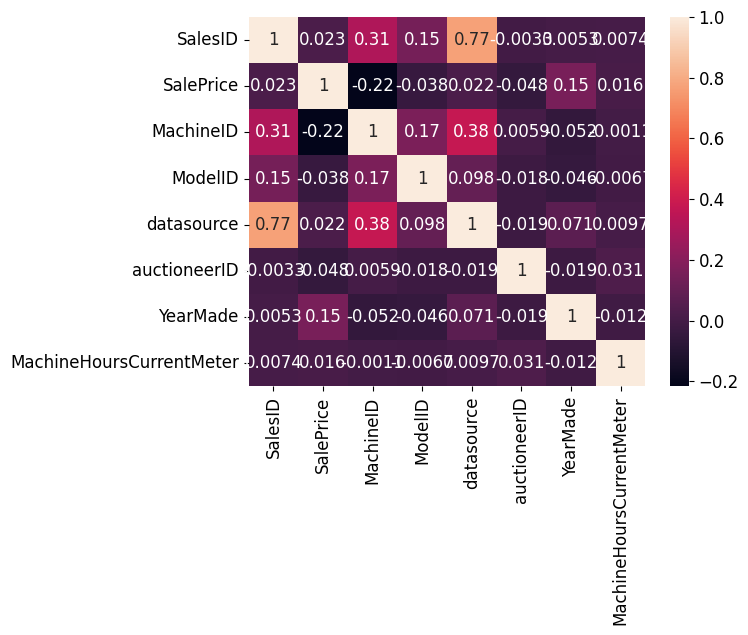

In [71]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [85]:
unique_counts = df.nunique()
md(f"**{len(df)} Rows**")
print(unique_counts.sort_values(ascending=False))

**412698 Rows**

SalesID                     412698
MachineID                   348808
MachineHoursCurrentMeter     15633
ModelID                       5281
fiModelDesc                   5059
saledate                      4013
fiBaseModel                   1961
SalePrice                      954
fiSecondaryDesc                177
fiModelDescriptor              140
fiModelSeries                  123
fiProductClassDesc              74
YearMade                        73
state                           53
auctioneerID                    30
Stick_Length                    29
Undercarriage_Pad_Width         19
Tire_Size                       17
Hydraulics                      12
Blade_Type                      10
Transmission                     8
Travel_Controls                  7
Enclosure                        6
Blade_Width                      6
datasource                       6
ProductSize                      6
ProductGroupDesc                 6
ProductGroup                     6
Steering_Controls   

In [82]:
columns_to_remove = ['SalesID']

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [92]:
object_df = df.select_dtypes(include=["object"])
object_df.nunique()

UsageBand                     3
saledate                   4013
fiModelDesc                5059
fiBaseModel                1961
fiSecondaryDesc             177
fiModelSeries               123
fiModelDescriptor           140
ProductSize                   6
fiProductClassDesc           74
state                        53
ProductGroup                  6
ProductGroupDesc              6
Drive_System                  4
Enclosure                     6
Forks                         2
Pad_Type                      4
Ride_Control                  3
Stick                         2
Transmission                  8
Turbocharged                  2
Blade_Extension               2
Blade_Width                   6
Enclosure_Type                3
Engine_Horsepower             2
Hydraulics                   12
Pushblock                     2
Ripper                        4
Scarifier                     2
Tip_Control                   3
Tire_Size                    17
Coupler                       3
Coupler_

In [94]:
unique_counts = df.nunique()
unique_counts

SalesID                     412698
SalePrice                      954
MachineID                   348808
ModelID                       5281
datasource                       6
auctioneerID                    30
YearMade                        73
MachineHoursCurrentMeter     15633
UsageBand                        3
saledate                      4013
fiModelDesc                   5059
fiBaseModel                   1961
fiSecondaryDesc                177
fiModelSeries                  123
fiModelDescriptor              140
ProductSize                      6
fiProductClassDesc              74
state                           53
ProductGroup                     6
ProductGroupDesc                 6
Drive_System                     4
Enclosure                        6
Forks                            2
Pad_Type                         4
Ride_Control                     3
Stick                            2
Transmission                     8
Turbocharged                     2
Blade_Extension     

# Creating a Baseline model

I want to make a very basic baseline model to predict the SalePrice based on just a small number of features. This will give me a metric to improve, and also force me to go through the motions of training a model, defining metrics, etc.

Here's the plan:
- Load the dataset
- Select columns: `["SalePrice", "YearMade", 'saledate']` 
- Ensure these columns are in acceptable condition (e.g. Replace NaNs, encode categorical data)
- Split into training and validation sets
- Train a model
- Make predictions against test set
- Submit to kaggle

In [1]:
from util import get_kaggle_dataset
path = get_kaggle_dataset("bluebook-for-bulldozers")

/home/john/.fastai/archive/bluebook-for-bulldozers already exists.
